<a href="https://colab.research.google.com/github/victor-onoja/DeepLearningLearning/blob/main/GenerativeDeepLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz


--2025-04-20 17:53:24--  https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  56.2MB/s    in 1.4s    

2025-04-20 17:53:25 (56.2 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



In [ ]:
!tar -xf aclImdb_v1.tar.gz

In [ ]:
import tensorflow as tf
from tensorflow import keras
dataset = keras.utils.text_dataset_from_directory(directory="aclImdb", label_mode=None, batch_size=256)
dataset = dataset.map(lambda x: tf.strings.regex_replace(x, "<br />", " "))

Found 100006 files.


In [ ]:
from tensorflow.keras.layers import TextVectorization

sequence_length = 100
vocab_size = 15000
text_vectorization = TextVectorization(max_tokens=vocab_size, output_mode="int", output_sequence_length=sequence_length)
text_vectorization.adapt(dataset)

In [ ]:
def prepare_lm_dataset(text_batch):
  vectorized_sequences = text_vectorization(text_batch)
  x = vectorized_sequences[:, :-1]
  y = vectorized_sequences[:, 1:]
  return x,y

lm_dataset = dataset.map(prepare_lm_dataset, num_parallel_calls=4)

In [ ]:
from tensorflow.keras import layers
embed_dim = 256
latent_dim = 2048
num_heads = 2

imputs = keras.Input(shape=(None,), dtype="int64")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, x)
outputs = layers.Dense(vocab_size, activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="sparse_categorical_crossentropy", optimizer="rmsprop")

NameError: name 'PositionalEmbedding' is not defined

In [ ]:
import numpy as np

tokens_index = dict(enumerate(text_vectorization.get_vocabulary()))

def sample_next(predictions, temperature=1.0):
  predictions = np.asarray(predictions).astype("float64")
  predictions = np.log(predictions) / temperature
  exp_preds = np.exp(predictions)
  predictions = exp_preds / np.sum(exp_preds)
  probas = np.random.multinomial(1, predictions, 1)
  return np.argmax(probas)


class TextGenerator(keras.callbacks.Callback):
  def __init__(self,
               prompt,
               generate_length,
               model_input_length,
               temperatures=(1.,),
               print_freq=1):
    self.prompt = prompt
    self.generate_length = generate_length
    self.model_input_length = model_input_length
    self.temperatures = temperatures
    self.print_freq = print_freq

  def on_epoch_end(self, epoch, logs=None):
    if (epoch + 1) % self.print_freq != 0:
      return
    for temperature in self.temperatures:
      print("== Generating with temperature", temperature)
      sentence = self.prompt
      for i in range(self.generate_length):
        tokenized_sentence = text_vectorization([sentence])
        predictions = self.model(tokenized_sentence)
        next_token = sample_next(predictions[0, i, :])
        sampled_token = tokens_index[next_token]
        sentence += " " + sampled_token
      print(sentence)

prompt = "This movie"
text_gen_callback = TextGenerator(prompt, generate_length=50, model_input_length=sequence_length, temperatures=(0.2, 0.5, 0.7, 1., 1.5))
model.fit(lm_dataset, epochs=200, callbacks=[text_gen_callback])


NameError: name 'model' is not defined

440742/440742 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step


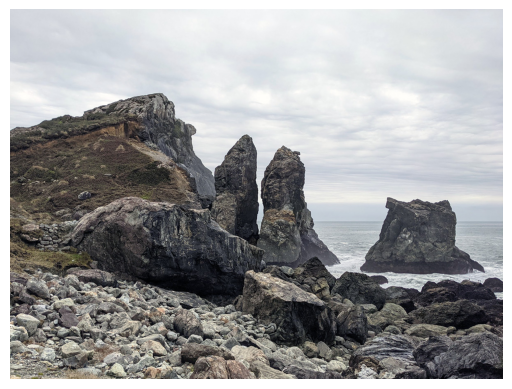

In [ ]:
from tensorflow import keras
import matplotlib.pyplot as plt

base_image_path = keras.utils.get_file("coast.jpg", origin="https://img-datasets.s3.amazonaws.com/coast.jpg")

plt.axis("off")
plt.imshow(keras.utils.load_img(base_image_path))

In [ ]:
from tensorflow.keras.applications import inception_v3
import tensorflow as tf
import numpy as np


model = inception_v3.InceptionV3(weights='imagenet', include_top=False)

layer_settings = {
    "mixed4": 1.0,
    "mixed5": 1.5,
    "mixed6": 2.0,
    "mixed7": 2.5,
}
outputs_dict = dict(
    [
        (layer.name, layer.output)
        for layer in [model.get_layer(name) for name in layer_settings.keys()]
    ]
)
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)


def compute_loss(input_image):
  features = feature_extractor(input_image)
  loss = tf.zeros(shape=())
  for name in features.keys():
    coeff = layer_settings[name]
    activation = features[name]
    loss += coeff * tf.reduce_mean(tf.square(activation[:, 2:-2, 2:-2, :]))
  return loss

@tf.function
def gradient_ascent_step(image, learning_rate):
  with tf.GradientTape() as tape:
    tape.watch(image)
    loss = compute_loss(image)
  grads = tape.gradient(loss, image)
  grads = tf.math.l2_normalize(grads)
  image += learning_rate * grads
  return loss, image

def gradient_ascent_loop(
    image, iterations, learning_rate, max_loss=None
):
  for i in range(iterations):
    loss, image = gradient_ascent_step(image, learning_rate)
    if max_loss is not None and loss > max_loss:
      break
    print(f"... Loss value at step {i}: {loss:.2f}")
  return image


step = 20.
num_octave = 3
octave_scale = 1.4
iterations = 30
max_loss = 15.

def preprocess_image(image_path):
  img = keras.utils.load_img(image_path)
  img = keras.utils.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = keras.applications.inception_v3.preprocess_input(img)
  return img

def deprocess_image(img):
  img = img.reshape((img.shape[1], img.shape[2], 3))
  img /= 2.0
  img += 0.5
  img *= 255.
  img = np.clip(img, 0, 255).astype("uint8")
  return img

original_img = preprocess_image(base_image_path)
original_shape = original_img.shape[1:3]

successive_shapes = [original_shape]
for i in range(1, num_octave):
  shape = tuple([int(dim / (octave_scale**i)) for dim in original_shape])
  successive_shapes.append(shape)

successive_shapes = successive_shapes[::-1]

shrunk_original_img = tf.image.resize(original_img, successive_shapes[0])

img = tf.identity(shrunk_original_img)
for i, shape in enumerate(successive_shapes):
  print(f"Processing octave {i} with shape {shape}")
  img = tf.image.resize(img, shape)
  img = gradient_ascent_loop(
      img, iterations=iterations, learning_rate=step, max_loss=max_loss)
  upscaled_shrunk_original_img = tf.image.resize(shrunk_original_img, shape)
  same_size_original = tf.image.resize(original_img, shape)
  lost_detail = same_size_original - upscaled_shrunk_original_img
  img += lost_detail
  shrunk_original_img = tf.image.resize(original_img, shape)

keras.utils.save_img("dream.png", deprocess_image(img.numpy()))

Processing octave 0 with shape (459, 612)


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_311']
Received: inputs=Tensor(shape=(1, 459, 612, 3))
  warnings.warn(msg)


... Loss value at step 0: 0.80
... Loss value at step 1: 1.07
... Loss value at step 2: 1.44
... Loss value at step 3: 1.82
... Loss value at step 4: 2.16
... Loss value at step 5: 2.49
... Loss value at step 6: 2.86
... Loss value at step 7: 3.21
... Loss value at step 8: 3.56
... Loss value at step 9: 3.93
... Loss value at step 10: 4.23
... Loss value at step 11: 4.60
... Loss value at step 12: 4.94
... Loss value at step 13: 5.27
... Loss value at step 14: 5.61
... Loss value at step 15: 6.02
... Loss value at step 16: 6.31
... Loss value at step 17: 6.70
... Loss value at step 18: 6.99
... Loss value at step 19: 7.40
... Loss value at step 20: 7.70
... Loss value at step 21: 8.04
... Loss value at step 22: 8.30
... Loss value at step 23: 8.63
... Loss value at step 24: 8.93
... Loss value at step 25: 9.25
... Loss value at step 26: 9.51
... Loss value at step 27: 9.86
... Loss value at step 28: 10.03
... Loss value at step 29: 10.35
Processing octave 1 with shape (642, 857)


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_311']
Received: inputs=Tensor(shape=(1, 642, 857, 3))
  warnings.warn(msg)


... Loss value at step 0: 1.58
... Loss value at step 1: 2.62
... Loss value at step 2: 3.44
... Loss value at step 3: 4.02
... Loss value at step 4: 4.55
... Loss value at step 5: 5.02
... Loss value at step 6: 5.50
... Loss value at step 7: 5.93
... Loss value at step 8: 6.34
... Loss value at step 9: 6.70
... Loss value at step 10: 7.08
... Loss value at step 11: 7.45
... Loss value at step 12: 7.78
... Loss value at step 13: 8.10
... Loss value at step 14: 8.44
... Loss value at step 15: 8.72
... Loss value at step 16: 9.02
... Loss value at step 17: 9.30
... Loss value at step 18: 9.58
... Loss value at step 19: 9.87
... Loss value at step 20: 10.13
... Loss value at step 21: 10.46
... Loss value at step 22: 10.66
... Loss value at step 23: 11.02
... Loss value at step 24: 11.19
... Loss value at step 25: 11.54
... Loss value at step 26: 11.75
... Loss value at step 27: 11.99
... Loss value at step 28: 12.27
... Loss value at step 29: 12.60
Processing octave 2 with shape (900, 120

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_311']
Received: inputs=Tensor(shape=(1, 900, 1200, 3))
  warnings.warn(msg)


... Loss value at step 0: 1.46
... Loss value at step 1: 2.28
... Loss value at step 2: 2.92
... Loss value at step 3: 3.43
... Loss value at step 4: 3.88
... Loss value at step 5: 4.28
... Loss value at step 6: 4.67
... Loss value at step 7: 5.07
... Loss value at step 8: 5.48
... Loss value at step 9: 5.83
... Loss value at step 10: 6.24
... Loss value at step 11: 6.58
... Loss value at step 12: 6.81
... Loss value at step 13: 7.22
... Loss value at step 14: 7.50
... Loss value at step 15: 7.77
... Loss value at step 16: 8.07
... Loss value at step 17: 8.32
... Loss value at step 18: 8.69
... Loss value at step 19: 8.89
... Loss value at step 20: 9.34
... Loss value at step 21: 9.57
... Loss value at step 22: 9.98
... Loss value at step 23: 10.01
... Loss value at step 24: 10.51
... Loss value at step 25: 10.68
... Loss value at step 26: 11.16
... Loss value at step 27: 11.29
... Loss value at step 28: 11.73
... Loss value at step 29: 12.00


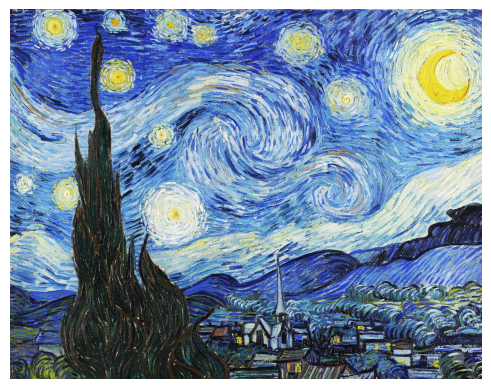

In [ ]:
base_image_path = keras.utils.get_file(
    "sf.jpg", origin="https://img-datasets.s3.amazonaws.com/sf.jpg"
)
style_reference_image_path = keras.utils.get_file(
    "starry_night.jpg",
    origin="https://img-datasets.s3.amazonaws.com/starry_night.jpg",
)
original_width, original_height = keras.utils.load_img(base_image_path).size
img_height = 400
img_width = round(original_width * img_height / original_height)
plt.axis("off")
plt.imshow(keras.utils.load_img(style_reference_image_path))


In [ ]:
# style transfer
import numpy as np
import tensorflow as tf

def preprocess_image(image_path):
  img = keras.utils.load_img(image_path, target_size=(img_height, img_width))
  img = keras.utils.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = keras.applications.vgg19.preprocess_input(img)
  return img

def deprocess_image(img):
  img = img.reshape((img_height, img_width, 3))
  img[:, :, 0] += 103.939
  img[:, :, 1] += 116.779
  img[:, :, 2] += 123.68
  img = img[:, :, ::-1]
  img = np.clip(img, 0, 255).astype("uint8")
  return img

model = keras.applications.vgg19.VGG19(weights="imagenet", include_top=False)

outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

def content_loss(base_img, combination_img):
  return tf.reduce_sum(tf.square(combination_img - base_img))

def gram_matrix(x):
  x = tf.transpose(x, (2, 0, 1))
  features = tf.reshape(x, (tf.shape(x)[0], -1))
  gram = tf.matmul(features, tf.transpose(features))
  return gram

def style_loss(style_img, combination_img):
  S = gram_matrix(style_img)
  C = gram_matrix(combination_img)
  channels = 3
  size = img_height * img_width
  return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

def total_variation_loss(x):
  a = tf.square(
      x[:, : img_height - 1, : img_width - 1, :] - x[:, 1:, : img_width - 1, :]
  )
  b = tf.square(
      x[:, : img_height - 1, : img_width - 1, :] - x[:, : img_height - 1, 1:, :]
  )
  return tf.reduce_sum(tf.pow(a + b, 1.25))

style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
content_layer_name = "block5_conv2"
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

def compute_loss(combination_image, base_image, style_reference_image):
  input_tensor = tf.concat(
      [base_image, style_reference_image, combination_image], axis=0
  )
  features = feature_extractor(input_tensor)
  loss = tf.zeros(shape=())
  layer_features = features[content_layer_name]
  base_image_features = layer_features[0, :, :, :]
  combination_features = layer_features[2,:, :, :]
  loss = loss + content_weight * content_loss(base_image_features, combination_features)
  for layer_name in style_layer_names:
    layer_features = features[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    style_loss_value = style_loss(style_reference_features, combination_features)
    loss += (style_weight / len(style_layer_names)) * style_loss_value
  loss += total_variation_weight * total_variation_loss(combination_image)
  return loss

@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
  with tf.GradientTape() as tape:
    loss = compute_loss(combination_image, base_image, style_reference_image)
  grads = tape.gradient(loss, combination_image)
  return loss, grads

optimizer = keras.optimizers.SGD(keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96))

base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

iterations = 4000
for i in range(1, iterations + 1):
  loss, grads = compute_loss_and_grads(combination_image, base_image, style_reference_image)
  optimizer.apply_gradients([(grads, combination_image)])
  if i % 100 == 0:
    print(f"Iteration {i}: loss={loss:.2f}")
    img = deprocess_image(combination_image.numpy())
    fname = f"combination_image_at_iteration_{i}.png"
    keras.utils.save_img(fname, img)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_622']
Received: inputs=Tensor(shape=(3, 400, 533, 3))
  warnings.warn(msg)


Iteration 100: loss=8138.06
Iteration 200: loss=6651.88
Iteration 300: loss=6061.70
Iteration 400: loss=5741.09
Iteration 500: loss=5534.68
Iteration 600: loss=5388.91
Iteration 700: loss=5279.28
Iteration 800: loss=5193.37
Iteration 900: loss=5124.16
Iteration 1000: loss=5067.17
Iteration 1100: loss=5019.28
Iteration 1200: loss=4978.53
Iteration 1300: loss=4943.28
Iteration 1400: loss=4912.46
Iteration 1500: loss=4885.30
Iteration 1600: loss=4861.24
Iteration 1700: loss=4839.80
Iteration 1800: loss=4820.61
Iteration 1900: loss=4803.26
Iteration 2000: loss=4787.52
Iteration 2100: loss=4773.18
Iteration 2200: loss=4760.04
Iteration 2300: loss=4747.98
Iteration 2400: loss=4736.85
Iteration 2500: loss=4726.59
Iteration 2600: loss=4717.11
Iteration 2700: loss=4708.33
Iteration 2800: loss=4700.19
Iteration 2900: loss=4692.63
Iteration 3000: loss=4685.59
Iteration 3100: loss=4679.03
Iteration 3200: loss=4672.89
Iteration 3300: loss=4667.13
Iteration 3400: loss=4661.74
Iteration 3500: loss=46

In [ ]:
# Variational Auto Encoders
from tensorflow import keras
from tensorflow.keras import layers

latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(
    32, 3, activation="relu", strides=2, padding="same"
)(encoder_inputs)
x = layers.Conv2D(
    64, 3, activation="relu", strides=2, padding="same"
)(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var], name="encoder")

In [ ]:
import tensorflow as tf

class Sampler(layers.Layer):
  def call(self, z_mean, z_log_var):
    batch_size = tf.shape(z_mean)[0]
    z_size = tf.shape(z_mean)[1]
    epsilon = tf.random.normal(shape=(batch_size, z_size))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(
    64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(
    32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2D(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

In [ ]:
class VAE(keras.Model):
  def __init__(self, encoder, decoder, **kwargs):
    super().__init__(**kwargs)
    self.encoder = encoder
    self.decoder = decoder
    self.sampler = Sampler()
    self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
    self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
    self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

  @property
  def metrics(self):
    return [
        self.total_loss_tracker,
        self.reconstruction_loss_tracker,
        self.kl_loss_tracker]

  def train_step(self, data):
    with tf.GradientTape() as tape:
      z_mean, z_log_var = self.encoder(data)
      z = self.sampler(z_mean, z_log_var)
      reconstruction = decoder(z)
      reconstruction_loss = tf.reduce_mean(
          tf.reduce_sum(
              keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
          )
      )
      kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
      total_loss = reconstruction_loss + tf.reduce_mean(kl_loss)
    grads = tape.gradient(total_loss, self.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
    self.total_loss_tracker.update_state(total_loss)
    self.reconstruction_loss_tracker.update_state(reconstruction_loss)
    self.kl_loss_tracker.update_state(kl_loss)
    return {
        "total_loss": self.total_loss_tracker.result(),
        "reconstruction_loss": self.reconstruction_loss_tracker.result(),
        "kl_loss": self.kl_loss_tracker.result(),
    }


In [ ]:
import numpy as np

(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(), run_eagerly=True)
vae.fit(mnist_digits, epochs=30, batch_size=128)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 100s 181ms/step - kl_loss: 2.6939 - reconstruction_loss: 246.3592 - total_loss: 249.0531
Epoch 2/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 103s 188ms/step - kl_loss: 2.6120 - reconstruction_loss: 184.7658 - total_loss: 187.3779
Epoch 3/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 134s 173ms/step - kl_loss: 3.7785 - reconstruction_loss: 162.5688 - total_loss: 166.3473
Epoch 4/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 82s 150ms/step - kl_loss: 3.8037 - reconstruction_loss: 156.9203 - total_loss: 160.7240
Epoch 5/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 75s 136ms/step - kl_loss: 3.8411 - reconstruction_loss: 153.8109 - total_loss: 157.6521
Epoch 6/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 79s 131ms/step - kl_loss: 3.8364 - reconstruction_loss: 152.2832 - total_loss: 156.1196
Epoch 7/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 74s 136ms/step - kl_loss: 3.8372 - reconstruction_loss: 150.5716 - total_loss: 154.4088
Epoch 8/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 81s 134ms/

In [3]:
import matplotlib.pyplot as plt
import numpy as np

n = 30
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = np.linspace(-1, 1, n)
grid_y = np.linspace(-1, 1, n)[::-1]

for i, yi in enumerate(grid_y):
  for j, xi in enumerate(grid_x):
    z_sample = np.array([[xi, yi]])
    x_decoded = vae.decoder.predict(z_sample)
    digit = x_decoded[0].reshape(digit_size, digit_size)
    figure[
      i * digit_size : (i + 1) * digit_size,
      j * digit_size : (j + 1) * digit_size,
    ] = digit

plt.figure(figsize=(15, 15))
start_range = digit_size // 2
end_range = n * digit_size + start_range
pixel_range = np.arange(start_range, end_range, digit_size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.axis("off")
plt.imshow(figure, cmap="Greys_r")


NameError: name 'vae' is not defined

In [4]:
!mkdir celeba_gan

In [6]:
!gdown --id 1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684 -O celeba_gan/data.zip

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684
From (redirected): https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684&confirm=t&uuid=bcce0429-ed7a-4dce-8be9-570b6dd3e26a
To: /content/celeba_gan/data.zip
100% 1.44G/1.44G [00:19<00:00, 73.2MB/s]


In [7]:
!unzip -qq celeba_gan/data.zip -d celeba_gan

Found 202599 files.


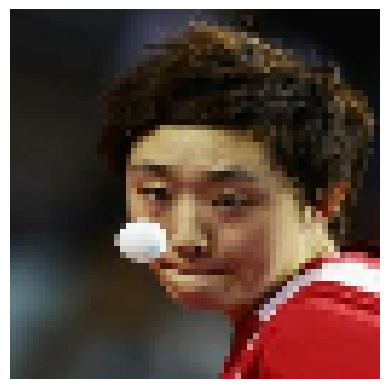

In [11]:
from tensorflow import keras
import matplotlib.pyplot as plt

dataset = keras.utils.image_dataset_from_directory(
    "celeba_gan", labels=None, image_size=(64, 64), batch_size=32
)
dataset = dataset.map(lambda x: x / 255.)
for x in dataset:
  plt.axis("off")
  plt.imshow((x.numpy() * 255).astype("int32")[0])
  break

In [13]:
from tensorflow.keras import layers

discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)

discriminator.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 404,801 (1.54 MB)

 Trainable params: 404,801 (1.54 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
latent_dim = 128
generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)

generator.summary()



/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 8192)           │     1,056,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 16, 16, 128)    │       262,272 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 32, 256)    │       524,544 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 64, 64, 512)    │     2,097,664 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 64, 64, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 3)      │        38,403 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,979,651 (15.18 MB)

 Trainable params: 3,979,651 (15.18 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import tensorflow as tf

class GAN(keras.Model):
  def __init__(self, discriminator, generator, latent_dim):
    super().__init__()
    self.discriminator = discriminator
    self.generator = generator
    self.latent_dim = latent_dim
    self.d_loss_metric = keras.metrics.Mean(name="d_loss")
    self.g_loss_metric = keras.metrics.Mean(name="g_loss")

  def compile(self, d_optimizer, g_optimizer, loss_fn):
    super(GAN, self).compile()
    self.d_optimizer = d_optimizer
    self.g_optimizer = g_optimizer
    self.loss_fn = loss_fn

  @property
  def metrics(self):
    return [self.d_loss_metric, self.g_loss_metric]

  def train_step(self, real_images):
    batch_size = tf.shape(real_images)[0]
    random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
    generated_images = self.generator(random_latent_vectors)
    combined_images = tf.concat([generated_images, real_images], axis=0)
    labels = tf.concat(
        [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
    )
    labels += 0.05 * tf.random.uniform(tf.shape(labels))
    with tf.GradientTape() as tape:
      predictions = self.discriminator(combined_images)
      d_loss = self.loss_fn(labels, predictions)
    grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
    self.d_optimizer.apply_gradients(
        zip(grads, self.discriminator.trainable_weights)
    )
    random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
    misleading_labels = tf.zeros((batch_size, 1))
    with tf.GradientTape() as tape:
      predictions = self.discriminator(self.generator(random_latent_vectors))
      g_loss = self.loss_fn(misleading_labels, predictions)
      grads = tape.gradient(g_loss, self.generator.trainable_weights)
      self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
    self.d_loss_metric.update_state(d_loss)
    self.g_loss_metric.update_state(g_loss)
    return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}


class GANMonitor(keras.callbacks.Callback):
  def __init__(self, num_img=3, latent_dim=128):
    self.num_img = num_img
    self.latent_dim = latent_dim

  def on_epoch_end(self, epoch, logs=None):
    random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
    generated_images = self.model.generator(random_latent_vectors)
    generated_images *= 255
    generated_images.numpy()
    for i in range(self.num_img):
      img = keras.utils.array_to_img(generated_images[i])
      img.save(f"generated_img_{epoch:03d}_{i}.png")


epochs = 100

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)])

Epoch 1/100
   3/6332 ━━━━━━━━━━━━━━━━━━━━ 59:27:06 34s/step - d_loss: 0.6875 - g_loss: 0.7540